# Data analysis and visualization

### Import libraries


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize

from os import path

### Load data

In [39]:
file_name = "lane_data.csv"
file_path = path.join("..", "..", "data", file_name)

# Load data
df = pd.read_csv(file_path, engine="pyarrow")
print(f"Data loaded from {file_path}, shape: {df.shape}")

# Filter to target lanes and drop ignored columns
target_lane_ids = ['eE_0', 'eE_out_0', 'eN_0', 'eN_out_0', 'eS_0', 'eS_out_0', 'eW_0', 'eW_out_0']
ignored_cols = ['step']
df = df[df['lane_id'].isin(target_lane_ids)].reset_index(drop=True)
df.drop(columns=ignored_cols, inplace=True)

# Display basic info
print("Shape after filtering and dropping columns:", df.shape, end="\n\n")
df.info()
print("\n" + df.tail().to_markdown())

Data loaded from ../../data/lane_data.csv, shape: (72000, 9)
Shape after filtering and dropping columns: (16000, 8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   time           16000 non-null  float64
 1   lane_id        16000 non-null  object 
 2   occupancy      16000 non-null  float64
 3   density        16000 non-null  float64
 4   vehicle_count  16000 non-null  int64  
 5   mean_speed     16000 non-null  float64
 6   waiting_time   16000 non-null  float64
 7   queue_length   16000 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 1000.1+ KB

|       |   time | lane_id   |   occupancy |   density |   vehicle_count |   mean_speed |   waiting_time |   queue_length |
|------:|-------:|:----------|------------:|----------:|----------------:|-------------:|---------------:|---------------:|
| 15995 |     50 | eN

### Introduce noise into the data

In [40]:
def introduce_realism(df: pd.DataFrame) -> pd.DataFrame:
    # Add Measurement Noise (numeric jitter)
    for col in ["occupancy", "density", "mean_speed", "waiting_time"]:
        std = df[col].std()
        noise = np.random.normal(0, 0.05 * std, size=len(df))  # 5% of std
        df[col] += noise

    # Introduce Missing or Corrupted Values
    mask = np.random.rand(len(df)) < 0.03  # 3% missing
    df.loc[mask, "mean_speed"] = np.nan

    mask = np.random.rand(len(df)) < 0.01
    df.loc[mask, "vehicle_count"] = 9999  # weird glitch values

    # Inject Logical Inconsistencies
    mask = np.random.rand(len(df)) < 0.05
    df.loc[mask, "occupancy"] *= np.random.uniform(0.5, 1.5, size=mask.sum())

    # Add Random Outliers
    for col in ["waiting_time", "density"]:
        outlier_idx = np.random.choice(df.index, size=int(0.01*len(df)), replace=False)
        df.loc[outlier_idx, col] *= np.random.uniform(2, 10)

    # Temporal Distortions (for time series realism)
    # Drop some timestamps
    df = df.sample(frac=0.98).sort_values("time").reset_index(drop=True)

    # Add small jitter to time
    df["time"] += np.random.normal(0, 0.05, size=len(df))

    # Category Noise
    lane_ids = df["lane_id"].unique()
    mask = np.random.rand(len(df)) < 0.02
    df.loc[mask, "lane_id"] = np.random.choice(lane_ids, size=mask.sum())

    # Combine With Synthetic Events
    event_idx = df.query("lane_id == 'eN_0' & time.between(25,35)").index
    df.loc[event_idx, ["mean_speed"]] *= 0.2
    df.loc[event_idx, ["waiting_time"]] *= 3
    
    # Randomize observations count for each lane
    for lane in df["lane_id"].unique():
        lane_df = df[df["lane_id"] == lane]
        drop_frac = np.random.uniform(0.05, 0.15)
        drop_idx = lane_df.sample(frac=drop_frac).index
        df = df.drop(index=drop_idx).reset_index(drop=True)

    return df

### Exploratory Data Analysis

Skipped values:
time               0
lane_id            0
occupancy          0
density            0
vehicle_count      0
mean_speed       432
waiting_time       0
queue_length       0
dtype: int64

Main statistics:
|       |          time |       occupancy |       density |   vehicle_count |   mean_speed |   waiting_time |   queue_length |
|:------|--------------:|----------------:|--------------:|----------------:|-------------:|---------------:|---------------:|
| count | 14099         | 14099           | 14099         |      14099      | 13667        |   14099        |   14099        |
| mean  |    25.0617    |     8.06948     |    17.5824    |         97.9346 |    10.9909   |       4.58429  |       0.448472 |
| std   |    14.392     |    14.0287      |    41.7719    |        977.19   |     4.34279  |      21.7546   |       1.79305  |
| min   |    -0.0446275 |    -2.68587     |   -33.1403    |          0      |    -0.453367 |     -14.1451   |       0        |
| 25%   |    12.603    

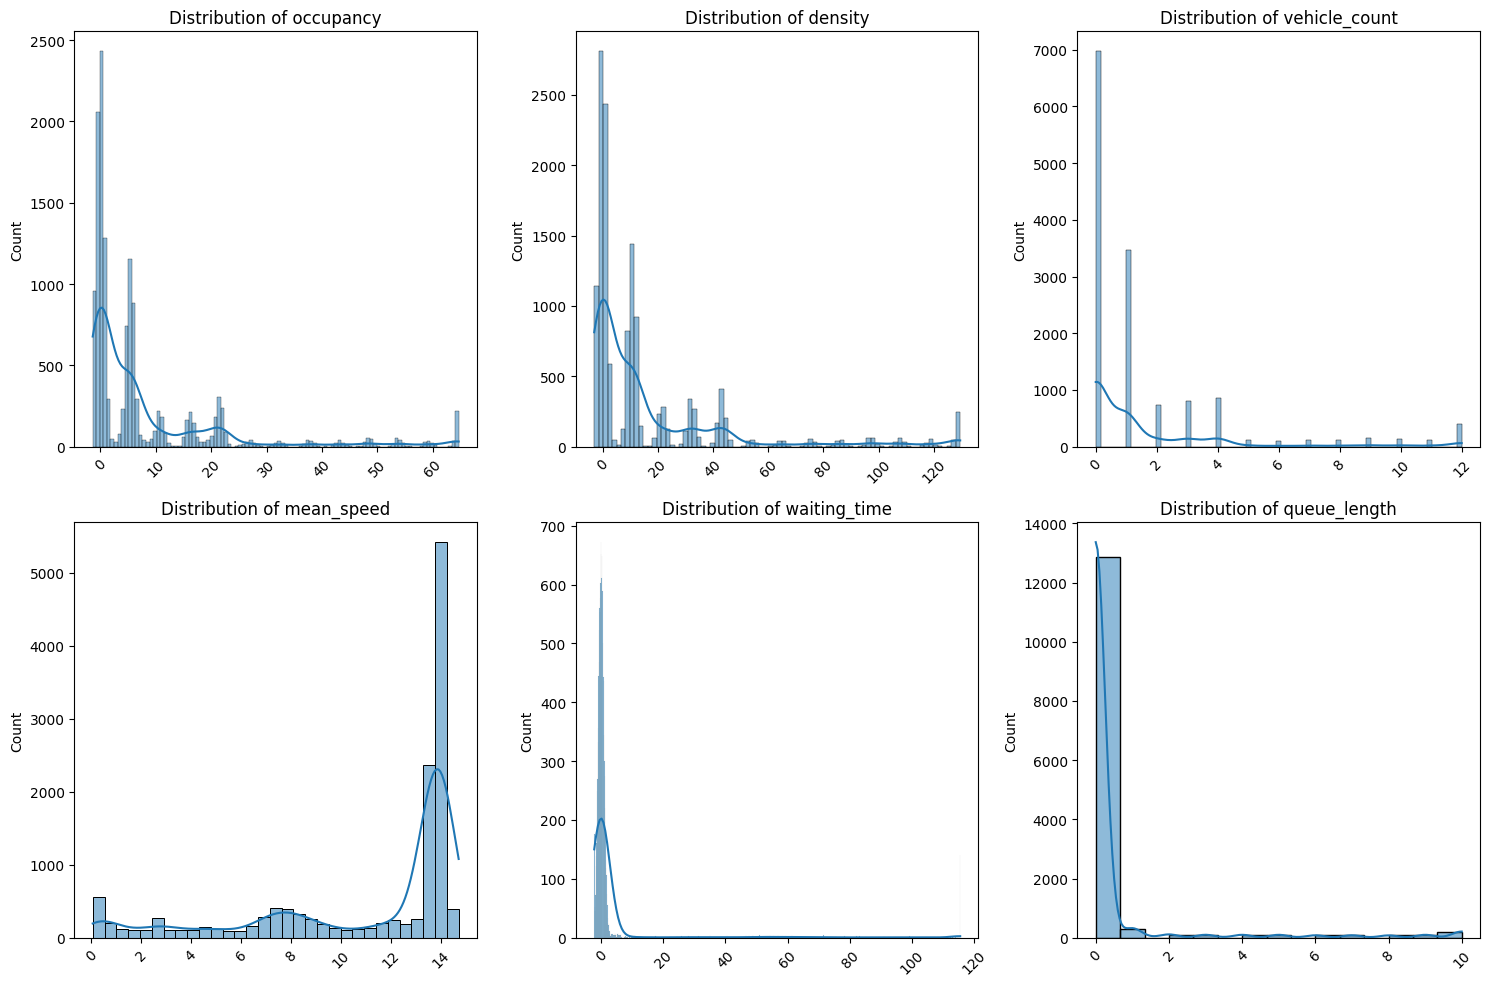

/mnt/shared/dev/traffic-zero/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/mnt/shared/dev/traffic-zero/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/mnt/shared/dev/traffic-zero/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


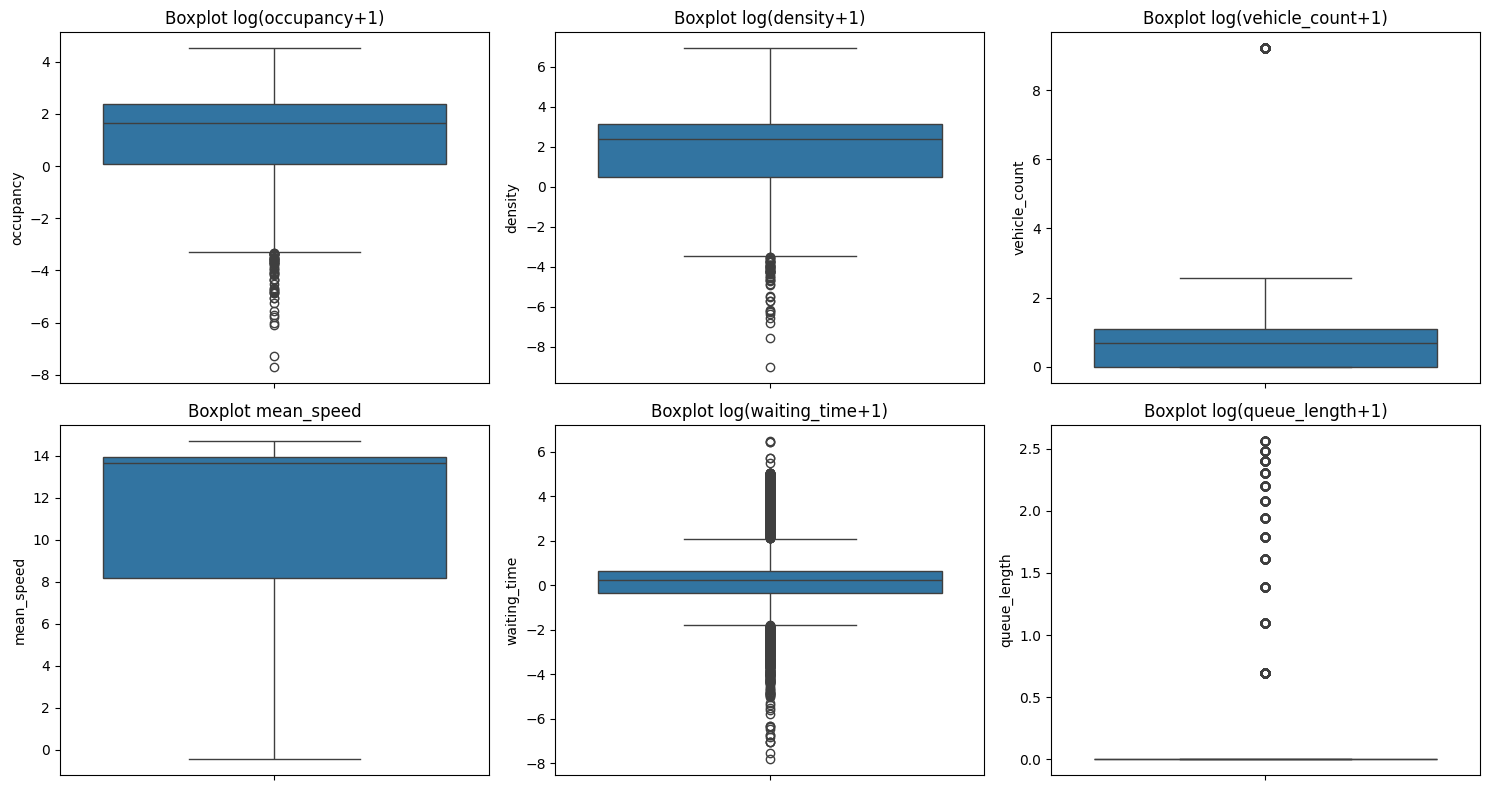

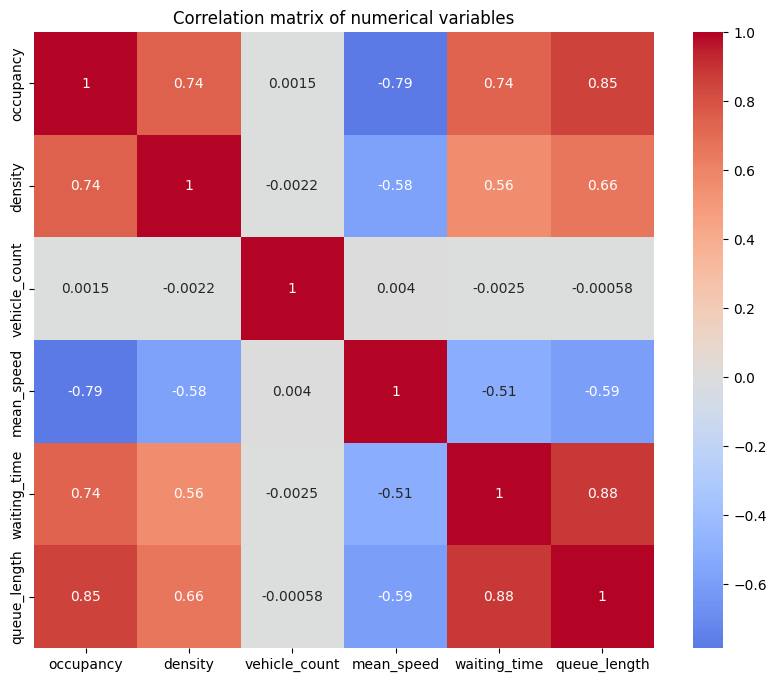

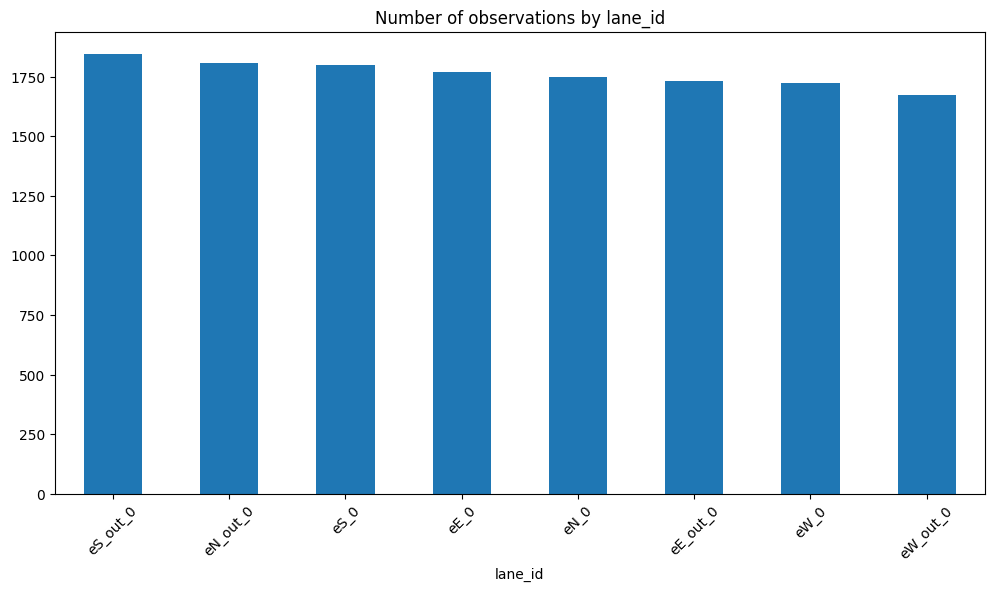

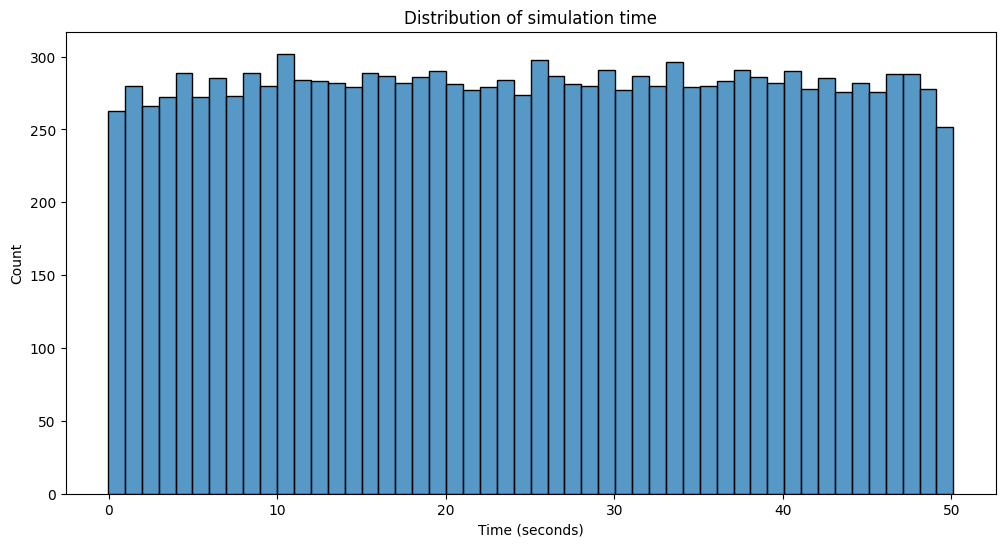

In [ ]:
# Introduce noise into the data
df = introduce_realism(df)

print("Skipped values:")
print(df.isnull().sum(), end="\n\n")

print("Main statistics:")
print(df.describe().to_markdown(), end="\n\n")

# Analyze distributions of numerical variables
numerical_cols = ["occupancy", "density", "vehicle_count", "mean_speed", "waiting_time", "queue_length"]

# Plot distributions
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)

    clipped = winsorize(df[col], limits=(0.01, 0.01))
    sns.histplot(clipped, kde=True)

    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Detecting outliers using boxplot
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)
    skewness = df[col].skew()

    # If data is heavily skewed or has massive outliers → log-scale
    if skewness > 2 or df[col].max() > df[col].quantile(0.99) * 10:
        sns.boxplot(y=np.log1p(df[col]))
        plt.title(f"Boxplot log({col}+1)")
    else:
        sns.boxplot(y=df[col])
        plt.title(f"Boxplot {col}")
plt.tight_layout()
plt.show()

# Correlation analysis
plt.figure(figsize=(10, 8))
correlation_matrix = df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation matrix of numerical variables")
plt.show()

# Analysis by lane_id
plt.figure(figsize=(12, 6))
df["lane_id"].value_counts().plot(kind="bar")
plt.title("Number of observations by lane_id")
plt.xticks(rotation=45)
plt.show()

# Time characteristics analysis
plt.figure(figsize=(12, 6))
sns.histplot(df["time"], bins=50)
plt.title("Distribution of simulation time")
plt.xlabel("Time (seconds)")
plt.show()

### Preprocess data

In [42]:
# Encoding categorical variable lane_id
print("Initial unique values of lane_id:")
print(df["lane_id"].unique(), end="\n\n")

# One-Hot Encoding for lane_id
lane_dummies = pd.get_dummies(df["lane_id"], prefix="lane")
df = pd.concat([df, lane_dummies], axis=1)

# Alternative: Label Encoding
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# df["lane_id_encoded"] = le.fit_transform(df["lane_id"])

print("Shape of the dataset after encoding lane_id:", df.shape, end="\n\n")

# Normalization of numerical variables
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_scaled = scaler.fit_transform(df[numerical_cols])
df_scaled = pd.DataFrame(numerical_scaled, columns=[f"{col}_scaled" for col in numerical_cols])
df = pd.concat([df, df_scaled], axis=1)

print("Dataset shape after scaling:", df.shape, end="\n\n")

# Check the first few rows of the processed dataset
print("First 5 rows after processing:")
print(df.head().to_markdown())

Initial unique values of lane_id:
['eW_out_0' 'eW_0' 'eS_0' 'eS_out_0' 'eE_0' 'eE_out_0' 'eN_out_0' 'eN_0']

Shape of the dataset after encoding lane_id: (14099, 16)

Dataset shape after scaling: (14099, 22)

First 5 rows after processing:
|    |        time | lane_id   |   occupancy |    density |   vehicle_count |   mean_speed |   waiting_time |   queue_length | lane_eE_0   | lane_eE_out_0   | lane_eN_0   | lane_eN_out_0   | lane_eS_0   | lane_eS_out_0   | lane_eW_0   | lane_eW_out_0   |   occupancy_scaled |   density_scaled |   vehicle_count_scaled |   mean_speed_scaled |   waiting_time_scaled |   queue_length_scaled |
|---:|------------:|:----------|------------:|-----------:|----------------:|-------------:|---------------:|---------------:|:------------|:----------------|:------------|:----------------|:------------|:----------------|:------------|:----------------|-------------------:|-----------------:|-----------------------:|--------------------:|----------------------:|-----